## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('..')
from medical_dataset import MedicalDataset
import models_mae

### Define utils

In [2]:
# define the utils

def show_image(image, title=''):
    # image is [H, W, 3]
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.50)
    y = model.unpatchify(y)
    y = y.detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 1)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = mask.detach().cpu()
    
    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [32, 32]

    plt.subplot(1, 4, 1)
    show_image(x[0, 0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0, 0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0, 0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0, 0], "reconstruction + visible")

    plt.show()

### Load an image

In [3]:
medical_dataset = MedicalDataset('/home/radu/Projects/mae-iter/config.json')

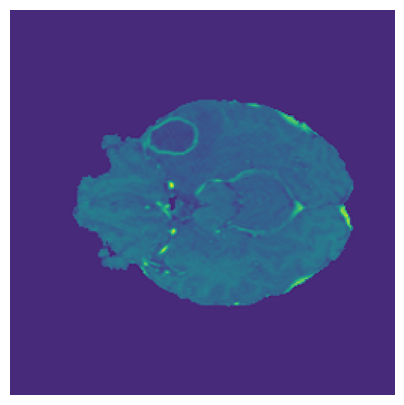

In [9]:
# load an image
img, _  = medical_dataset.__getitem__(980)

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img[0]))

### Load a pre-trained MAE model

In [5]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist

chkpt_dir = '/home/radu/Projects/mae-iter/output_dir/checkpoint-1400.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


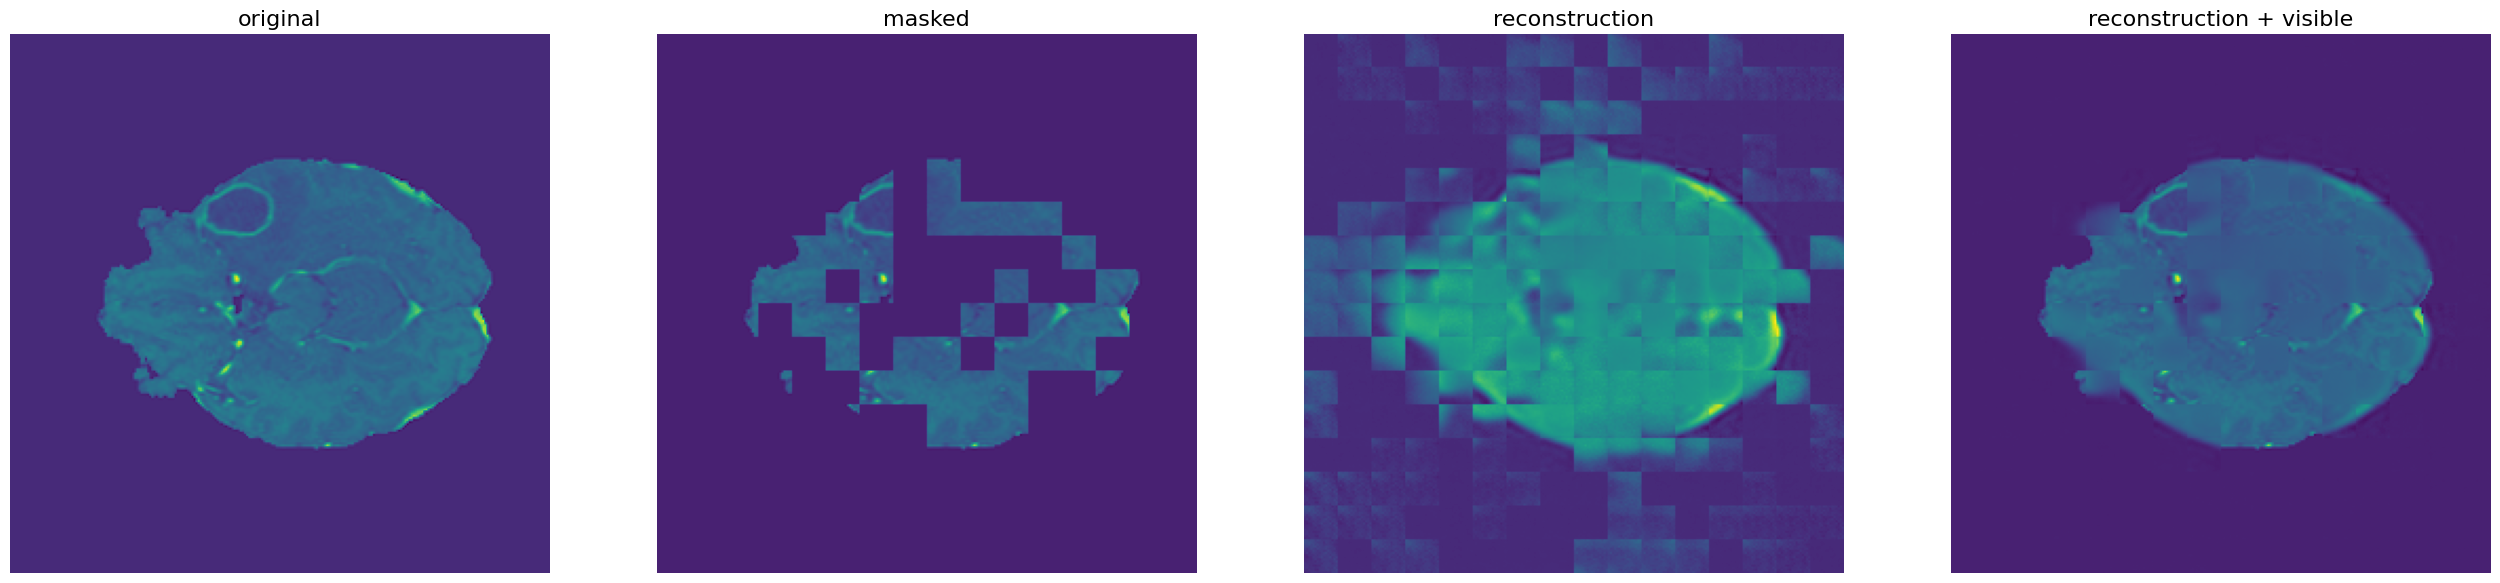

In [10]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)